# Things to explore:
Formulate hypthesis and test it accordinly.


1. Check correlation between different features. Will it make sense to eliminate the redundant features having strong correlations?e.g. physical health and gen health.

2. what are the top 3 deciding features? How does the model works with just these 3 features vs all 21 features?

3. Try different methods to find out 3 top features.

4. Will creating balanced dataset yield any different results for the model accuracy?

5. What other different models can we implement?

6. Look for existing research in diabetes field and what questions do they answer. Can we think of any alternative ways to test?

#Reference
https://www.cdc.gov/pcd/issues/2019/19_0109.htm


Read this paper and try to think of couple of questions that we need to answer as a part of this project.



# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from google.colab import drive


drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Reading and cleaning data

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Diabetes Project/2015.csv")
df_selected = df[['DIABETE3',
                            '_RFHYPE5',
                           'TOLDHI2',
                            '_BMI5',
                           'SMOKE100',
                           'CVDSTRK3',
                           '_MICHD',
                           '_TOTINDA',
                           '_RFDRHV5',
                           'MENTHLTH',
                          #  'PHYSHLTH',
                           'ADDEPEV2',
                           'EXERANY2',
                            'GENHLTH',
                           'SEX',
                           '_AGEG5YR',
                           'INCOME2',
                            'CHCKIDNY']]


#Rename the columns to make them more readable
data = df_selected.rename(columns = {'DIABETE3':'Diabetes',
                                         '_RFHYPE5':'High_BP',
                                         'TOLDHI2':'High_Cholestrol',
                                         '_BMI5':'BMI',
                                         'SMOKE100':'Smoker',
                                         'CVDSTRK3':'Stroke',
                                         '_MICHD':'Heart_Disease',
                                         '_TOTINDA':'Physical_Activity',
                                         '_RFDRHV5':'Heavy_Alcohol_Consumption',
                                         'MENTHLTH':'Mental_Health',
                                        #  'PHYSHLTH':'Physical_Health',
                                         'ADDEPEV2': 'Depression',
                                         'EXERANY2': 'Exercise',
                                         'GENHLTH':'General_Health',
                                         'SEX':'Sex',
                                         '_AGEG5YR':'Age',
                                         'INCOME2':'Income',
                                         'DECIDE': 'Decision',
                                         'CHCKIDNY': 'Kidney_Disease' })

data.dropna(inplace=True)
data.head()

data['Diabetes'] = data['Diabetes'].replace({2:0, 3:0, 4:0, 1:1})
data = data[data['Diabetes'] != 7]
data = data[data['Diabetes'] != 9]

data['High_BP'] = data['High_BP'].replace({1:0, 2:1})
data = data[data['High_BP'] != 9]

data['High_Cholestrol'] = data['High_Cholestrol'].replace({2:0})
data = data[data['High_Cholestrol'] != 7]
data = data[data['High_Cholestrol'] != 9]

data = data[data['General_Health'] != 7]
data = data[data['General_Health'] != 9]

data['Smoker'] = data['Smoker'].replace({2:0})
data = data[data['Smoker'] != 7]
data = data[data['Smoker'] != 9]

data['Stroke'] = data['Stroke'].replace({2:0})
data = data[data['Stroke'] != 7]
data = data[data['Stroke'] != 9]

data['Heart_Disease'] = data['Heart_Disease'].replace({2: 0})

data['Physical_Activity'] = data['Physical_Activity'].replace({2:0})
data = data[data['Physical_Activity'] != 9]

data['Heavy_Alcohol_Consumption'] = data['Heavy_Alcohol_Consumption'].replace({1:0, 2:1})
data = data[data['Heavy_Alcohol_Consumption'] != 9]

data['Mental_Health'] = data['Mental_Health'].replace({88:0})
data = data[data['Mental_Health'] != 77]
data = data[data['Mental_Health'] != 99]

# data['Physical_Health'] = data['Physical_Health'].replace({88:0})
# data = data[data['Physical_Health'] != 77]
# data = data[data['Physical_Health'] != 99]

data['Sex'] = data['Sex'].replace({2:0})

data = data[data['Income'] != 77]
data = data[data['Income'] != 99]

data.groupby(['Diabetes']).size()

f1 = []
accuracies = []
precisions = []
recalls = []
roc_aucs = []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Utility Functions

In [ ]:
def print_accu_preci_recall(y_test, y_pred):
  print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
  accuracies.append(metrics.accuracy_score(y_test, y_pred))

  # Model Precision: what percentage of positive tuples are labeled as such?
  print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))
  precisions.append(metrics.precision_score(y_test, y_pred, average='weighted'))

  # Model Recall: what percentage of positive tuples are labelled as such?
  print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))
  recalls.append(metrics.recall_score(y_test, y_pred, average='weighted'))

  print("F1-Score:",metrics.f1_score(y_test, y_pred, average='weighted'))
  f1.append(metrics.f1_score(y_test, y_pred, average='weighted'))



def print_confusion_matrix_classification_report(y_test, y_pred):
  print("confusion matrix")
  print(confusion_matrix(y_test, y_pred))
  print('-' * 100)
  print("classification report")
  print(classification_report(y_test, y_pred))


def draw_roc_auc(y_test, y_pred, model_name):
  roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
  roc_aucs.append(roc_auc)
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  plt.figure()
  plt.plot(fpr, tpr, label=f'{model_name} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig(f'{model_name}_ROC')
  plt.show()

# Creating balanced dataset

In [ ]:
data_1 = data[data['Diabetes'] == 1]
data_0 = data[data['Diabetes'] == 0]

data_0 = data_0.take(np.random.permutation(len(data_0))[:37367])
balanced_data = data_0.append(data_1, ignore_index = True)

balanced_data.groupby(['Diabetes']).size()

Diabetes
0.0    37367
1.0    38350
dtype: int64

# Splitting data into train and test data

In [ ]:
X = data.iloc[:,1:19]  #independent columns
y = data['Diabetes']    #target column i.e price range
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Splitting balanced data into train and test data

In [ ]:
X_balanced = balanced_data.iloc[:,1:19]  #independent columns
y_balanced = balanced_data['Diabetes']    #target column i.e price range
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

# Correlation

,Diabetes,High_BP,High_Cholestrol,BMI,Smoker,Stroke,Heart_Disease,Physical_Activity,Heavy_Alcohol_Consumption,Mental_Health,Depression,Exercise,General_Health,Sex,Age,Income,Kidney_Disease
Diabetes,1.000000,0.263077,0.200330,0.216970,0.059761,0.105474,0.176352,-0.118185,-0.057105,0.068599,-0.057291,0.118185,0.292154,0.029915,0.175944,-0.165796,-0.058980
High_BP,0.263077,1.000000,0.299970,0.211494,0.095140,0.131572,0.210539,-0.125994,-0.004882,0.056097,-0.052319,0.125994,0.300687,0.048016,0.343329,-0.173449,-0.050010
High_Cholestrol,0.200330,0.299970,1.000000,0.106507,0.091446,0.092846,0.181459,-0.077959,-0.012347,0.063493,-0.080216,0.077959,0.208744,0.028851,0.266927,-0.086740,-0.031595
BMI,0.216970,0.211494,0.106507,1.000000,0.011799,0.019077,0.051482,-0.144662,-0.047700,0.083147,-0.089293,0.144662,0.232908,0.041767,-0.041191,-0.096563,-0.020296
Smoker,0.059761,0.095140,0.091446,0.011799,1.000000,0.060298,0.115069,-0.086476,0.101006,0.092247,-0.076655,0.086476,0.161802,0.097408,0.116039,-0.121054,-0.009865
Stroke,0.105474,0.131572,0.092846,0.019077,0.060298,1.000000,0.204267,-0.070197,-0.017069,0.070384,-0.050067,0.070197,0.179045,0.003689,0.129451,-0.130514,-0.041795
Heart_Disease,0.176352,0.210539,0.181459,0.051482,0.115069,0.204267,1.000000,-0.087874,-0.029196,0.064933,-0.047480,0.087874,0.259540,0.085439,0.220228,-0.142375,-0.060397
Physical_Activity,-0.118185,-0.125994,-0.077959,-0.144662,-0.086476,-0.070197,-0.087874,1.000000,0.012168,-0.123495,0.073129,-1.000000,-0.267682,0.034097,-0.096895,0.200971,0.026297
Heavy_Alcohol_Consumption,-0.057105,-0.004882,-0.012347,-0.047700,0.101006,-0.017069,-0.029196,0.012168,1.000000,0.025738,-0.012663,-0.012168,-0.037749,0.007187,-0.036552,0.054742,0.011735
Mental_Health,0.068599,0.056097,0.063493,0.083147,0.092247,0.070384,0.064933,-0.123495,0.025738,1.000000,-0.332296,0.123495,0.299381,-0.078463,-0.092565,-0.207093,-0.020263


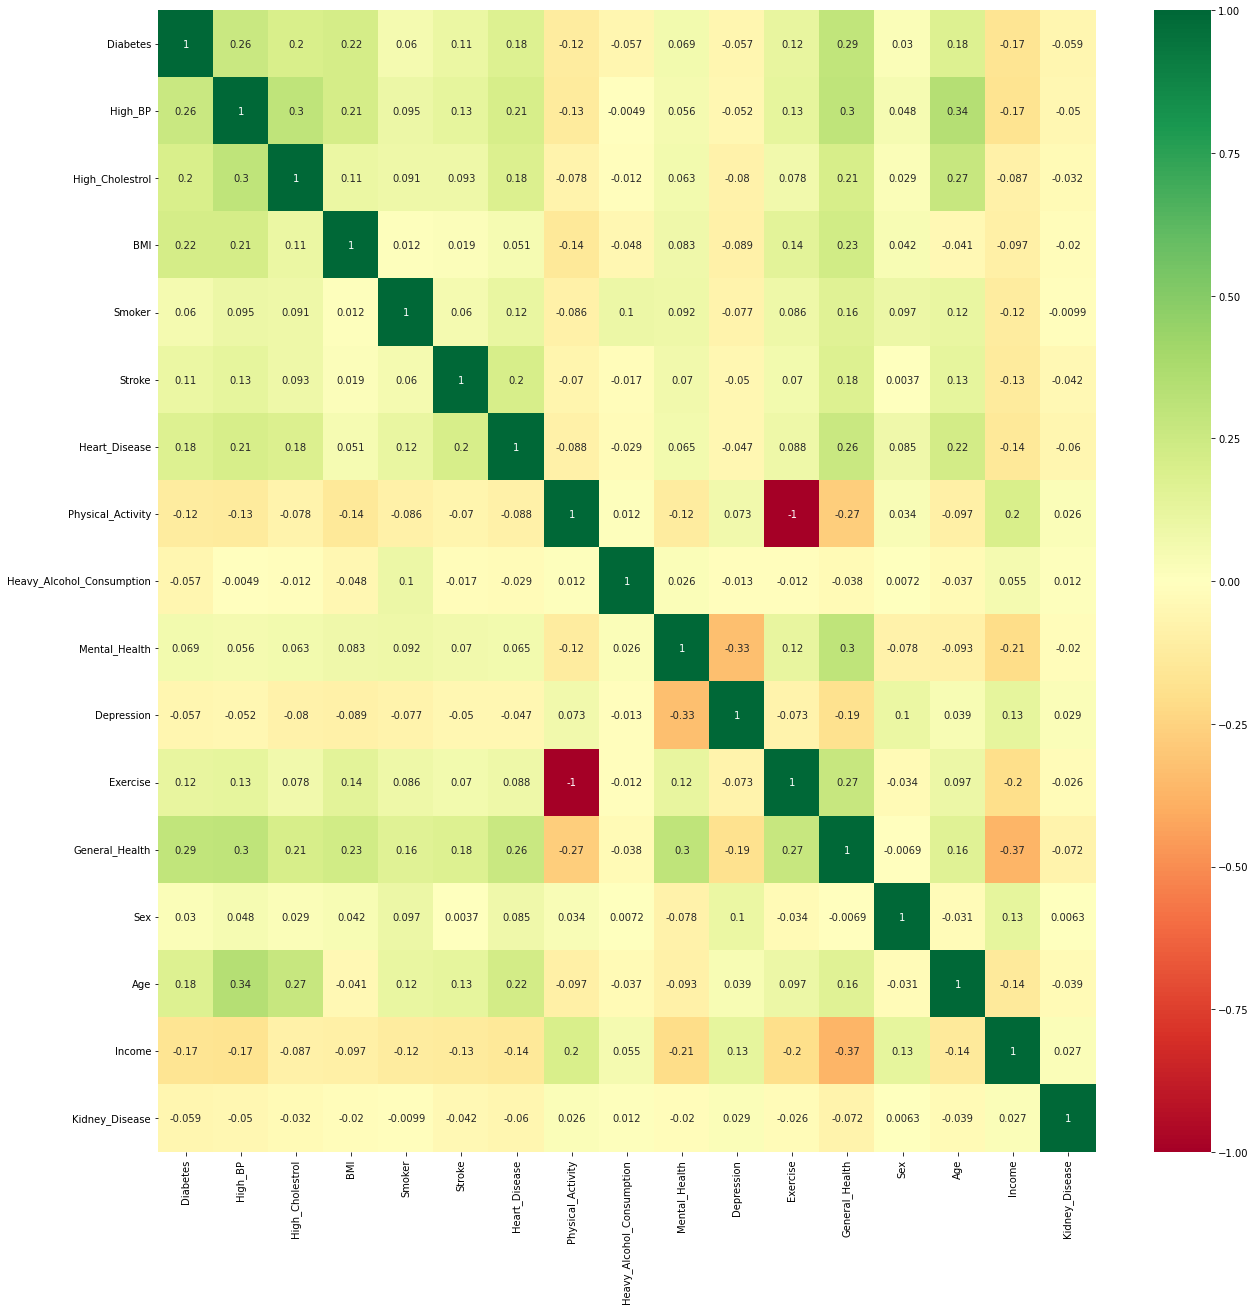

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(21,21))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")
corrmat

From correlation it is clear that probability of diabetes increases with increase in high bp, high bmi, low general health

# Try Univariate Selection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

data.shape

                Specs         Score
2                 BMI  1.958608e+06
8       Mental_Health  2.209917e+04
0             High_BP  1.060292e+04
11     General_Health  1.054570e+04
13                Age  9.883586e+03
5       Heart_Disease  7.600321e+03
1     High_Cholestrol  6.244097e+03
14             Income  5.433744e+03
4              Stroke  2.882026e+03
6   Physical_Activity  9.425033e+02


(270555, 17)

# Try with decision tree feature importance

[0.04760471 0.02367559 0.43687789 0.01895565 0.00933627 0.01656679
 0.00454431 0.00579527 0.0840454  0.02663689 0.00451287 0.06759828
 0.01658776 0.12788379 0.09086899 0.01850954]


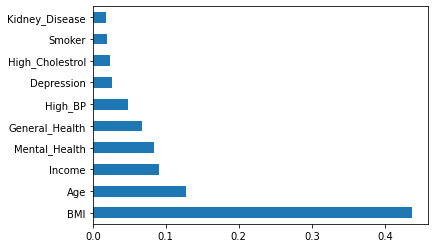

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier


model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Decision tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# With skewed data

# Create Decision Tree classifer object
deci_tree_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
deci_tree_clf = deci_tree_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_deci_tree_pred = deci_tree_clf.predict(X_test)


# With balanced data

# # Create Decision Tree classifer object
# deci_tree_clf = DecisionTreeClassifier()

# # Train Decision Tree Classifer
# deci_tree_clf = deci_tree_clf.fit(X_balanced_train, y_balanced_train)

# #Predict the response for test dataset
# y_balanced_deci_tree_pred = deci_tree_clf.predict(X_balanced_test)



# Decision tree Stats

Accuracy: 0.6538122908962846
Precision: 0.6538652730401928
Recall: 0.6538122908962846
F1-Score: 0.6538271055504694
----------------------------------------------------------------------------------------------------
confusion matrix
[[7311 3884]
 [3980 7541]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65     11195
         1.0       0.66      0.65      0.66     11521

    accuracy                           0.65     22716
   macro avg       0.65      0.65      0.65     22716
weighted avg       0.65      0.65      0.65     22716

----------------------------------------------------------------------------------------------------


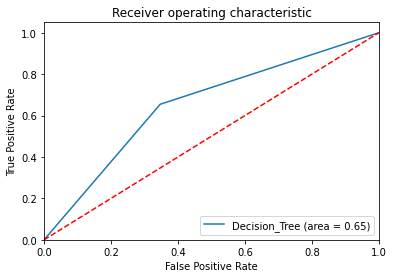

----------------------------------------------------------------------------------------------------


In [ ]:
# With Skewed Data
print_accu_preci_recall(y_test, y_deci_tree_pred)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, y_deci_tree_pred)
print('-' * 100)
draw_roc_auc(y_test, y_deci_tree_pred, model_name="Decision_Tree")
print('-' * 100)

# # With balanced Data
# print_accu_preci_recall(y_balanced_test, y_balanced_deci_tree_pred)
# print('-' * 100)
# print_confusion_matrix_classification_report(y_balanced_test, y_balanced_deci_tree_pred)
# print('-' * 100)
# draw_roc_auc(y_balanced_test, y_balanced_deci_tree_pred, model_name="Decision_Tree")
# print('-' * 100)



# Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

gaus_clf = GaussianNB()
gaus_clf.fit(X_train, y_train)
y_gaus_pred = gaus_clf.predict(X_test)


# # With balanced data
# gaus_clf = DecisionTreeClassifier()
# gaus_clf = gaus_clf.fit(X_balanced_train, y_balanced_train)
# y_balanced_gaus_pred = gaus_clf.predict(X_balanced_test)


# Gaussian Naive Bayes stats

Accuracy: 0.6543845747490755
Precision: 0.6544608238955695
Recall: 0.6543845747490755
F1-Score: 0.654401597039573
----------------------------------------------------------------------------------------------------
confusion matrix
[[7334 3861]
 [3990 7531]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65     11195
         1.0       0.66      0.65      0.66     11521

    accuracy                           0.65     22716
   macro avg       0.65      0.65      0.65     22716
weighted avg       0.65      0.65      0.65     22716

----------------------------------------------------------------------------------------------------


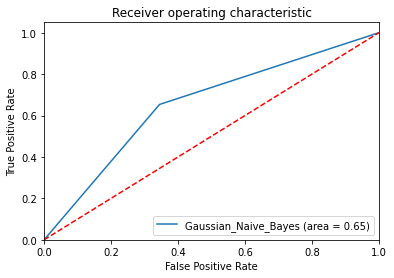

----------------------------------------------------------------------------------------------------


In [ ]:
# With Skewed Data
print_accu_preci_recall(y_test, y_gaus_pred)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, y_gaus_pred)
print('-' * 100)
draw_roc_auc(y_test, y_gaus_pred, model_name="Gaussian_Naive_Bayes")
print('-' * 100)

# # With balanced Data
# print_accu_preci_recall(y_balanced_test, y_balanced_gaus_pred)
# print('-' * 100)
# print_confusion_matrix_classification_report(y_balanced_test, y_balanced_gaus_pred)
# print('-' * 100)
# draw_roc_auc(y_balanced_test, y_balanced_gaus_pred, model_name="Gaussian_Naive_Bayes")
# print('-' * 100)



# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, y_train)
y_logreg_pred = logreg_clf.predict(X_test)


# # With balanced data
# logreg_clf = DecisionTreeClassifier()
# logreg_clf = logreg_clf.fit(X_balanced_train, y_balanced_train)
# y_balanced_logreg_pred = logreg_clf.predict(X_balanced_test)

# Logistic regression stats

Accuracy: 0.6526237013558726
Precision: 0.6526814630066327
Recall: 0.6526237013558726
F1-Score: 0.6526391653047925
----------------------------------------------------------------------------------------------------
confusion matrix
[[7301 3894]
 [3997 7524]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65     11195
         1.0       0.66      0.65      0.66     11521

    accuracy                           0.65     22716
   macro avg       0.65      0.65      0.65     22716
weighted avg       0.65      0.65      0.65     22716

----------------------------------------------------------------------------------------------------


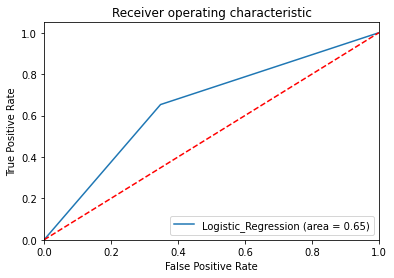

----------------------------------------------------------------------------------------------------


In [ ]:
# With Skewed Data
print_accu_preci_recall(y_test, y_logreg_pred)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, y_logreg_pred)
print('-' * 100)
draw_roc_auc(y_test, y_logreg_pred, model_name="Logistic_Regression")
print('-' * 100)

# # With balanced Data
# print_accu_preci_recall(y_balanced_test, y_balanced_logreg_pred)
# print('-' * 100)
# print_confusion_matrix_classification_report(y_balanced_test, y_balanced_logreg_pred)
# print('-' * 100)
# draw_roc_auc(y_balanced_test, y_balanced_logreg_pred, model_name="Logistic_Regression")
# print('-' * 100)



# ANN Model

In [ ]:
import tensorflow as tf

# With Skewed data
#Initialising ANN
ann = tf.keras.models.Sequential()
 #Adding First Hidden Layer
ann.add(tf.keras.layers.Dense(units=10,activation="relu"))
 #Adding Second Hidden Layer
ann.add(tf.keras.layers.Dense(units=10,activation="relu"))
#Adding Output Layer
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
# Fitting ANN
ann.fit(X_train,y_train,batch_size=256 ,epochs = 10) #, validation_split=0.2)
#Predicting result for Single Observation
y_ann_pred_bool =  ann.predict(X_test) > 0.5


# # With balanced data

# #Initialising ANN
# ann_balanced = tf.keras.models.Sequential()
#  #Adding First Hidden Layer
# ann_balanced.add(tf.keras.layers.Dense(units=6,activation="relu"))
#  #Adding Second Hidden Layer
# ann_balanced.add(tf.keras.layers.Dense(units=6,activation="relu"))
# #Adding Output Layer
# ann_balanced.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
# #Compiling ANN
# ann_balanced.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])
# # Fitting ANN
# ann_balanced.fit(X_balanced_train,y_balanced_train,batch_size=256,epochs = 100, validation_split=0.2)
# #Predicting result for Single Observation
# y_balanced_pred_bool =  model.predict(X_balanced_test) > 0.5



Epoch 1/10
740/740 [==============================] - 3s 3ms/step - loss: 2.5770 - accuracy: 0.8432
Epoch 2/10
740/740 [==============================] - 2s 3ms/step - loss: 0.3850 - accuracy: 0.8557
Epoch 3/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3673 - accuracy: 0.8544
Epoch 4/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3591 - accuracy: 0.8544
Epoch 5/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3580 - accuracy: 0.8540
Epoch 6/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3604 - accuracy: 0.8534
Epoch 7/10
740/740 [==============================] - 2s 3ms/step - loss: 0.3525 - accuracy: 0.8551
Epoch 8/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3575 - accuracy: 0.8541
Epoch 9/10
740/740 [==============================] - 2s 2ms/step - loss: 0.3497 - accuracy: 0.8563
Epoch 10/10
2537/2537 [==============================] - 4s 1ms/step


# ANN Stats

2537/2537 [==============================] - 5s 2ms/step
Accuracy: 0.85570490470265
Precision: 0.8323898581653794
Recall: 0.85570490470265
F1-Score: 0.839763867998301
----------------------------------------------------------------------------------------------------
confusion matrix
[[66171  3543]
 [ 8169  3284]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92     69714
         1.0       0.48      0.29      0.36     11453

    accuracy                           0.86     81167
   macro avg       0.69      0.62      0.64     81167
weighted avg       0.83      0.86      0.84     81167

----------------------------------------------------------------------------------------------------


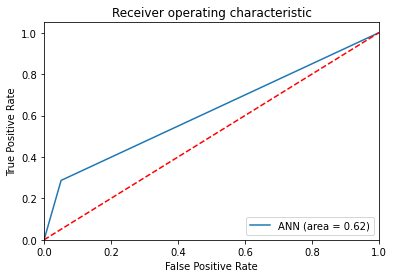

----------------------------------------------------------------------------------------------------


In [ ]:
y_ann_pred_bool =  ann.predict(X_test) > 0.5
# With Skewed Data
print_accu_preci_recall(y_test, y_ann_pred_bool)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, y_ann_pred_bool)
print('-' * 100)
draw_roc_auc(y_test, y_ann_pred_bool, model_name="ANN")
print('-' * 100)

# # With balanced Data
# print_accu_preci_recall(y_balanced_test, y_balanced_pred_bool)
# print('-' * 100)
# print_confusion_matrix_classification_report(y_balanced_test, y_balanced_pred_bool)
# print('-' * 100)
# draw_roc_auc(y_balanced_test, y_balanced_pred_bool, model_name="ANN")
# print('-' * 100)

# Random Forest

In [ ]:

from sklearn.ensemble import RandomForestRegressor

# With Skewed data
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, max_depth=5)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test) > 0.5


# # With balanced data
# rf_balanced = RandomForestRegressor()#n_estimators = 1000, random_state = 42, max_depth=5)
# rf_balanced.fit(X_balanced_train, y_balanced_train)
# y_rf_balanced_pred = rf_balanced.predict(X_balanced_test)

In [ ]:
np.count_nonzero(y_rf_pred < 0.5)

74949

Accuracy: 0.8628137050771866
Precision: 0.8287491965099453
Recall: 0.8628137050771866
F1-Score: 0.8227404665291054
----------------------------------------------------------------------------------------------------
confusion matrix
[[68636  1078]
 [10057  1396]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     69714
         1.0       0.56      0.12      0.20     11453

    accuracy                           0.86     81167
   macro avg       0.72      0.55      0.56     81167
weighted avg       0.83      0.86      0.82     81167

----------------------------------------------------------------------------------------------------


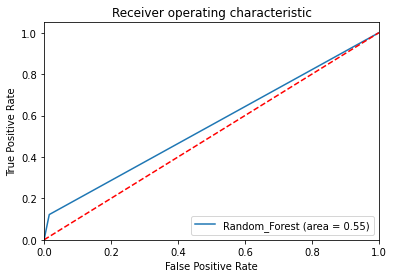

----------------------------------------------------------------------------------------------------


In [ ]:
# With Skewed Data
print_accu_preci_recall(y_test, y_rf_pred)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, y_rf_pred)
print('-' * 100)
draw_roc_auc(y_test, y_rf_pred, model_name="Random_Forest")
print('-' * 100)


# # With balanced Data
# print_accu_preci_recall(y_balanced_test, y_rf_balanced_pred)
# print('-' * 100)
# print_confusion_matrix_classification_report(y_balanced_test, y_rf_balanced_pred)
# print('-' * 100)
# draw_roc_auc(y_balanced_test, y_rf_balanced_pred, model_name="ANN")
# print('-' * 100)

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


knn_model = KNeighborsRegressor(n_neighbors=9)

knn_model.fit(X_train, y_train)

# Calculate the accuracy of the model


# print(np.nonzero_count(test_preds))

print(knn_model.score(X_test, y_test))

0.06830602748255632


Accuracy: 0.851565291312972
Precision: 0.8040070230123726
Recall: 0.851565291312972
F1-Score: 0.813455386419183
----------------------------------------------------------------------------------------------------
confusion matrix
[[67847  1867]
 [10181  1272]]
----------------------------------------------------------------------------------------------------
classification report
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92     69714
         1.0       0.41      0.11      0.17     11453

    accuracy                           0.85     81167
   macro avg       0.64      0.54      0.55     81167
weighted avg       0.80      0.85      0.81     81167

----------------------------------------------------------------------------------------------------


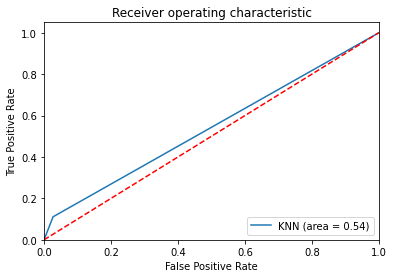

----------------------------------------------------------------------------------------------------


In [ ]:
test_preds = knn_model.predict(X_test) > 0.5

# With Skewed Data
print_accu_preci_recall(y_test, test_preds)
print('-' * 100)
print_confusion_matrix_classification_report(y_test, test_preds)
print('-' * 100)
draw_roc_auc(y_test, test_preds, model_name="KNN")
print('-' * 100)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)




print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred, average='weighted'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred, average='weighted'))

KeyboardInterrupt: ignored

In [ ]:


#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)






# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics

# # Model Accuracy: how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# # Model Precision: what percentage of positive tuples are labeled as such?
# print("Precision:",metrics.precision_score(y_test, y_pred))

# # Model Recall: what percentage of positive tuples are labelled as such?
# print("Recall:",metrics.recall_score(y_test, y_pred))

# SVM for prediction